# AEBS
Demonstration of `AOBxFAC_2F` product.

In [1]:
from viresclient import SwarmRequest

start_time="2015-06-01T00:00:00Z"
end_time="2015-06-02T00:00:00Z"

#start_time="2015-06-01T10:00:00Z"
#end_time="2015-06-01T18:00:00Z"     

#start_time="2015-06-01T00:40:00Z"
#end_time="2015-06-01T01:39:00Z"


try:
    request = SwarmRequest("https://staging.viresdisc.vires.services/ows")

    request.set_collection("SW_OPER_AOBAFAC_2F")
    request.set_products(
        measurements=[
            'Latitude_QD', 'Longitude_QD', 'MLT_QD', 'Boundary_Flag',
            'Quality', 'Pair_Indicator',
        ],
        auxiliaries=['QDOrbitDirection'],
        sampling_step="PT1S",       # 1 second sampling
    )

    response = request.get_between(
        start_time=start_time,
        end_time=end_time
    )
    data = response.as_xarray()

    request.set_collection("SW_OPER_MAGA_LR_1B")
    request.set_products(
        measurements=[],
        auxiliaries=['QDLat', 'MLT'],
        sampling_step="PT1S",       # 1 second sampling
    )

    response = request.get_between(
        start_time=start_time,
        end_time=end_time
    )
    orbit = response.as_xarray()
    
    
except Exception as error:
    print("ERROR: ", error)
else:
    print(data)
    print(orbit)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.106MB)
[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (4.238MB)


<xarray.Dataset>
Dimensions:           (Quality_dim1: 2, Timestamp: 100)
Coordinates:
  * Timestamp         (Timestamp) datetime64[ns] 2015-06-01T00:39:56.500000 ... 2015-06-01T23:26:29.500000
Dimensions without coordinates: Quality_dim1
Data variables:
    Spacecraft        (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude          (Timestamp) float64 72.77 80.74 75.97 ... -87.26 -75.78
    Longitude         (Timestamp) float64 -168.6 -161.2 -9.866 ... 95.84 -170.6
    Radius            (Timestamp) float64 6.821e+06 6.82e+06 ... 6.839e+06
    Latitude_QD       (Timestamp) float64 70.4 79.01 75.43 ... -77.08 -74.39
    Longitude_QD      (Timestamp) float64 -115.8 -125.6 87.67 ... 23.12 -38.02
    MLT_QD            (Timestamp) float64 12.34 11.72 2.03 ... 1.21 20.36 16.34
    Boundary_Flag     (Timestamp) uint8 1 2 2 1 1 2 2 1 1 ... 1 2 1 1 2 2 1 1 1
    Quality           (Timestamp, Quality_dim1) float64 0.5108 0.2589 ... 0.2392
    Pair_Indicator    (Timestamp) int8

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


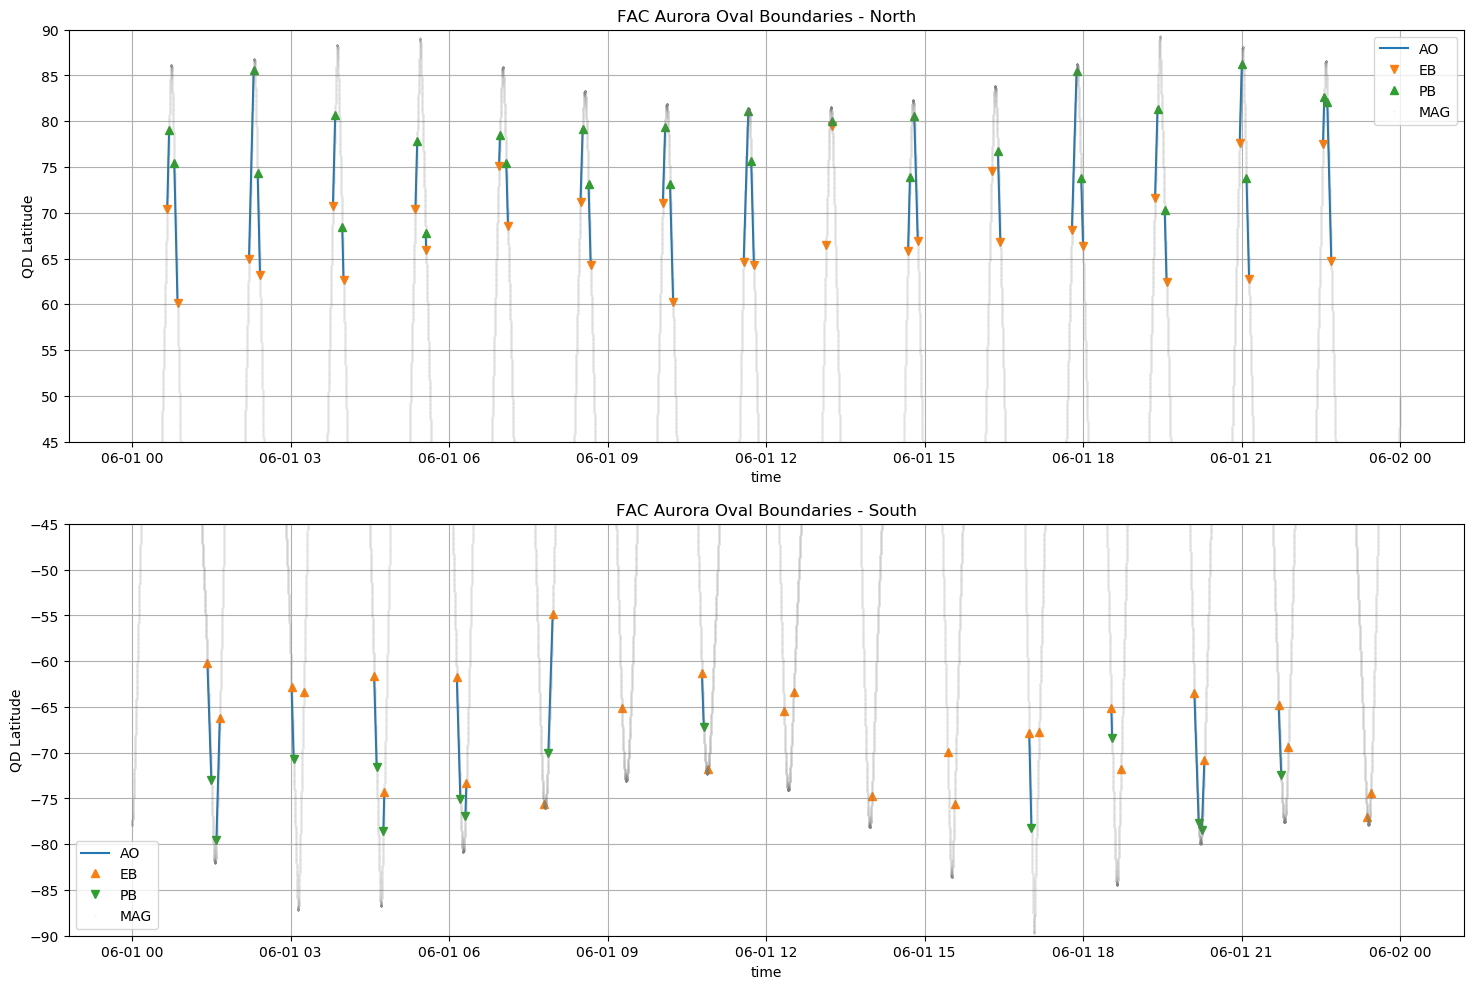

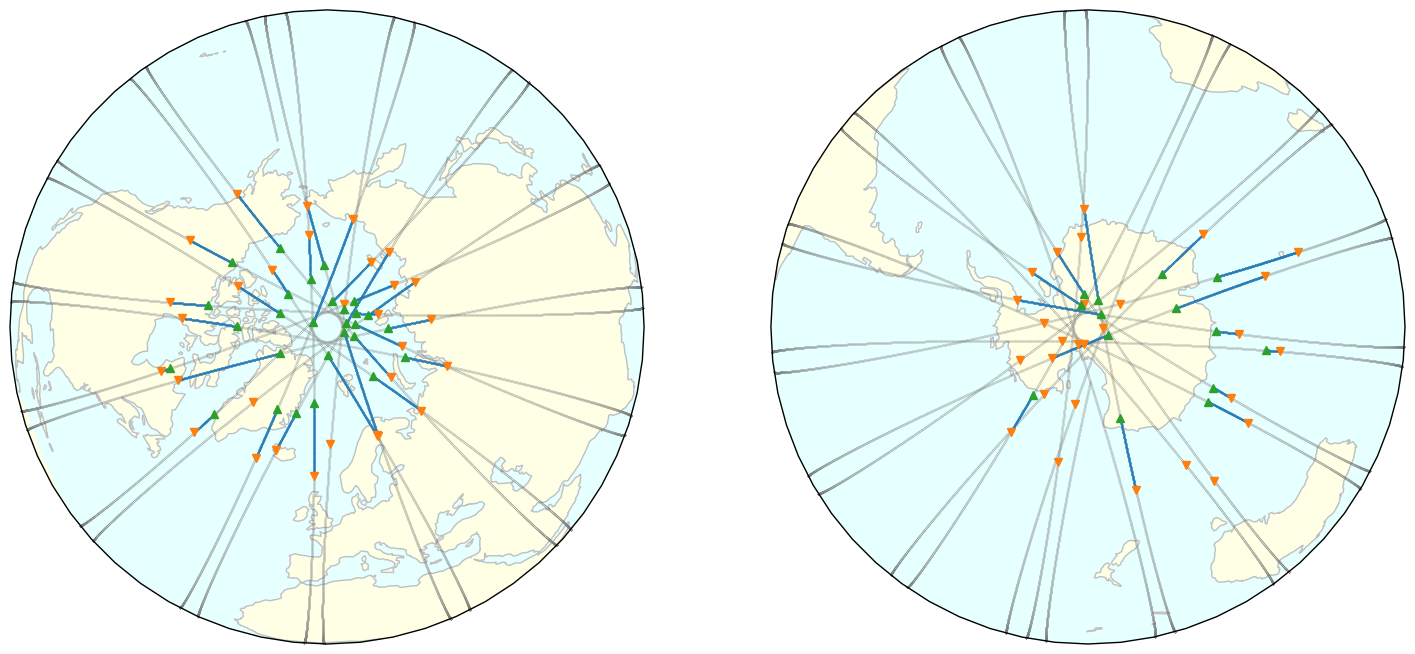

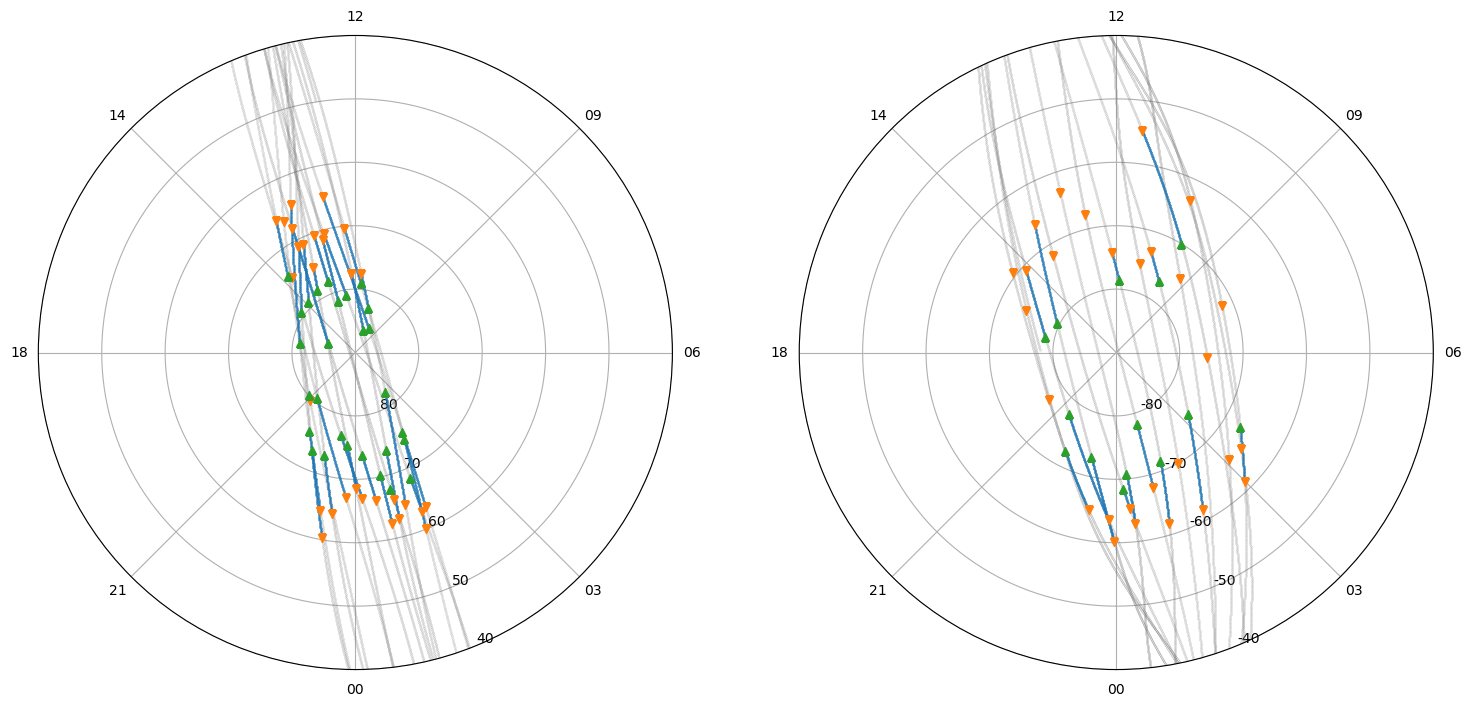

In [2]:
from numpy import isnan, logical_and, abs as aabs, cumsum, stack, pi
from matplotlib.pyplot import figure, subplot, show
from scipy.interpolate import interp1d
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree
%matplotlib inline

# AOB data
lat_qd = data['Latitude_QD'].values
mlt = data['MLT_QD'].values
lat = data['Latitude'].values
lon = data['Longitude'].values
time = data['Timestamp'].values
flag = data['Boundary_Flag'].values
pair_indicator = data['Pair_Indicator'].values
orbit_direction = data['QDOrbitDirection'].values
hemisphere = (lat_qd > 0)*2 - 1 

mask_eb = flag == 1
mask_pb = flag == 2

idx_start, = (pair_indicator == +1).nonzero()
idx_end, = (pair_indicator == -1).nonzero()

# strip incomplete 
dsize = idx_start.size - idx_end.size 
if dsize == 0:
    if idx_start.size and idx_start[0] > idx_end[0]:
        idx_end = idx_end[1:]
        idx_start = idx_start[:-1]
elif dsize == -1: # starting point is missing
    idx_end = idx_end[1:]
elif dsize == +1: # end point is missing
    idx_start = idx_start[:-1]
else:
    raise Exception("Boundaries mismatch!")

# orbit read from MAGx_LR
orbit_time = orbit['Timestamp'].values
orbit_lat_qd = orbit['QDLat'].values
orbit_lat = orbit['Latitude'].values
orbit_lon = orbit['Longitude'].values
orbit_mlt = orbit['MLT'].values

# AO mask -> True if point is inside AO
mask_ao = interp1d(
    time.astype('int64'), pair_indicator==1, kind="zero", bounds_error=False, fill_value=0.0
)(orbit_time.astype('int64')).astype('bool')

# plotting
idx = stack((idx_start, idx_end), axis=0)

fig = figure(figsize=(18, 12), dpi=100)

def plot_qdlat_vs_time(ax, ylim, label): 
    is_north = min(ylim) > 0
    l_cn, = ax.plot(time[idx], lat_qd[idx], '-', color='tab:blue')[:1]
    l_eb, = ax.plot(time[mask_eb], lat_qd[mask_eb], 'v' if is_north else '^', color='tab:orange')
    l_pb, = ax.plot(time[mask_pb], lat_qd[mask_pb], '^' if is_north else 'v', color='tab:green')
    l_orb, = ax.plot(orbit_time, orbit_lat_qd, '.', markersize=0.1, color='tab:gray')
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title("FAC Aurora Oval Boundaries - %s" % label)
    ax.set_ylabel('QD Latitude')
    ax.set_xlabel('time')
    ax.legend((l_cn, l_eb, l_pb, l_orb), ('AO', 'EB', 'PB', 'MAG'));

plot_qdlat_vs_time(subplot(211), (45, 90), "North")
plot_qdlat_vs_time(subplot(212), (-90, -45), "South")

fig = figure(figsize=(18, 9), dpi=100)

def plot_maps(ax):
    gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=0, color='silver', alpha=0.5, linestyle='--')
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')
    ax.plot(orbit_lon[~mask_ao], orbit_lat[~mask_ao], '.', markersize=0.1, color='tab:gray', transform=PlateCarree())
    ax.plot(orbit_lon[mask_ao], orbit_lat[mask_ao], '.', markersize=0.5, color='tab:blue', transform=PlateCarree())
    #ax.plot(lon[idx], lat[idx], '-', color='tab:blue', transform=PlateCarree())
    ax.plot(lon[mask_eb], lat[mask_eb], 'v', color='tab:orange', transform=PlateCarree())
    ax.plot(lon[mask_pb], lat[mask_pb], '^', color='tab:green', transform=PlateCarree())

plot_maps(subplot(1, 2, 1, projection=Orthographic(0, 90)))
plot_maps(subplot(1, 2, 2, projection=Orthographic(0, -90)))

fig = figure(figsize=(18, 9), dpi=100)

def plot_mlt(ax, north=True):
    ax.set_theta_zero_location("S")
    h = 1 if north else -1
    
    def _plot(x, y, *args, **kwargs):
        return ax.plot(x*(pi/12), 90 - y*h, *args, **kwargs)

    _plot(orbit_mlt[~mask_ao], orbit_lat_qd[~mask_ao], '.', markersize=0.1, color='tab:gray')
    _plot(orbit_mlt[mask_ao], orbit_lat_qd[mask_ao], '.', markersize=0.5, color='tab:blue')
    _plot(mlt[mask_eb], lat_qd[mask_eb], 'v', color='tab:orange')
    _plot(mlt[mask_pb], lat_qd[mask_pb], '^', color='tab:green')
    
    ax.set_ylim(0, 50)
    ax.set_xticklabels(["%2.2i" % (x*12/pi) for x in ax.get_xticks()])
    ax.set_yticklabels(["%.0f" % ((90 - y)*h) for y in ax.get_yticks()])
    
plot_mlt(subplot(1, 2, 1, projection='polar'), north=True)
plot_mlt(subplot(1, 2, 2, projection='polar'), north=False)